In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
from scipy.stats import ttest_ind

# Data Processing

In [2]:
def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)

Make a nested dictionary that will contain everything that we need. Get the data out of tf event files.

In [3]:
algorithms = ['PPO']
games = ['Breakout', 'Centipede', 'VideoPinball']
modes = ['Video', 'Audio Video']
seeds = ['1946482810', '2430240526', '3829621125', '4246035910']
experiments = {}

In [4]:
# Iterate through algorithms, games, modes and seeds to make a dict
for i in algorithms:
    experiments[i] = {}
    for j in games:
        experiments[i][j] = {}
        for k in modes:
            experiments[i][j][k]= {}
            # Used to save results across different seeds to get the average reward df at the end
            step_rew_all_seeds = []
            for l in seeds:
                path = '../experiments/{}/{}/{}/{}/'.format(i, j, k, l)
                print(path)
                # Add the full dataframe to the dict
                experiments[i][j][k][l] = {'data' : convert_tb_data(path)}
                # Add mean episode rewards out of full df to the dict as another key-value pair
                # to make our life easier later on.
                full_df = experiments[i][j][k][l]['data']
                step = full_df[full_df['name'] == 'rollout/ep_rew_mean']['step']
                ep_rew_mean = full_df[full_df['name'] == 'rollout/ep_rew_mean']['value']
                step_rew_dict = {'step': step, 'ep_rew_mean' : ep_rew_mean}
                step_rew_df = pd.DataFrame(step_rew_dict)
                experiments[i][j][k][l]['ep_rew_mean'] = step_rew_df   
                step_rew_all_seeds.append(step_rew_df)
            # Add an average episode rewards across all the seeds
            experiments[i][j][k]['average_ep_rew_mean'] = pd.concat(step_rew_all_seeds).groupby(level=0).mean()

../experiments/PPO/Breakout/Video/1946482810/
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
../experiments/PPO/Breakout/Video/2430240526/
../experiments/PPO/Breakout/Video/3829621125/
../experiments/PPO/Breakout/Video/4246035910/
../experiments/PPO/Breakout/Audio Video/1946482810/
../experiments/PPO/Breakout/Audio Video/2430240526/
../experiments/PPO/Breakout/Audio Video/3829621125/
../experiments/PPO/Breakout/Audio Video/4246035910/
../experiments/PPO/Centipede/Video/1946482810/
../experiments/PPO/Centipede/Video/2430240526/
../experiments/PPO/Centipede/Video/3829621125/
../experiments/PPO/Centipede/Video/4246035910/
../experiments/PPO/Centipede/Audio Video/1946482810/
../experiments/PPO/Centipede/Audio Video/2430240526/
../experiments/PPO/Centipede/Audio Video/3829621125/
../experiments/PPO/Centipede/Audio Video/4246035910/
../experiments/PPO/VideoPinball/Video/1946482810/
../experiments/PPO/VideoPinball/Video/2430240526/
../experiments/PPO/Vide

In [5]:
experiments

{'PPO': {'Breakout': {'Video': {'1946482810': {'data':           wall_time                        name      step       value
     0      1.629304e+09         rollout/ep_len_mean      2048  588.466675
     1      1.629304e+09         rollout/ep_rew_mean      2048    0.533333
     2      1.629304e+09                    time/fps      2048  118.000000
     3      1.629304e+09         rollout/ep_len_mean      4096  595.344849
     4      1.629304e+09         rollout/ep_rew_mean      4096    0.620690
     ...             ...                         ...       ...         ...
     58582  1.629464e+09    train/explained_variance  10000384    0.884633
     58583  1.629464e+09         train/learning_rate  10000384    0.000300
     58584  1.629464e+09                  train/loss  10000384   -0.042049
     58585  1.629464e+09  train/policy_gradient_loss  10000384   -0.034890
     58586  1.629464e+09            train/value_loss  10000384    0.041974
     
     [58587 rows x 4 columns],
     'ep_rew_

# Data Visualization

In [6]:
breakout_video = experiments[algorithms[0]][games[0]][modes[0]]['average_ep_rew_mean']
breakout_video_audio = experiments[algorithms[0]][games[0]][modes[1]]['average_ep_rew_mean']
centipede_video = experiments[algorithms[0]][games[1]][modes[0]]['average_ep_rew_mean']
centipede_video_audio = experiments[algorithms[0]][games[1]][modes[1]]['average_ep_rew_mean']
videopinball_video = experiments[algorithms[0]][games[2]][modes[0]]['average_ep_rew_mean']
videopinball_video_audio = experiments[algorithms[0]][games[2]][modes[1]]['average_ep_rew_mean']

## Visualize experiments

### Breakout

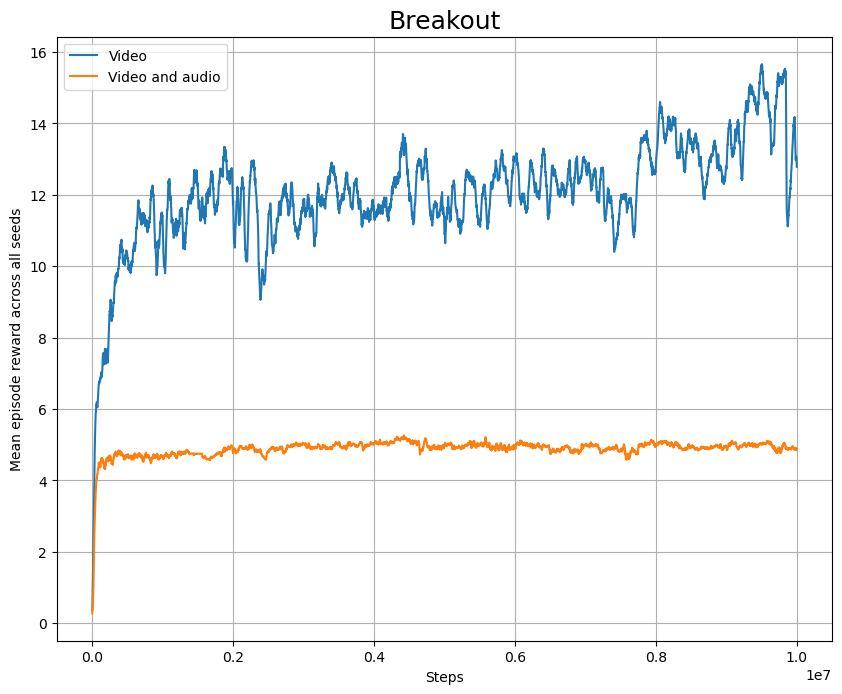

In [7]:
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(breakout_video['step'], breakout_video['ep_rew_mean'], label='Video')
plt.plot(breakout_video_audio['step'], breakout_video_audio['ep_rew_mean'], label='Video and audio')
plt.title('Breakout', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds')
plt.legend()
plt.grid()
plt.show()

### Centipede

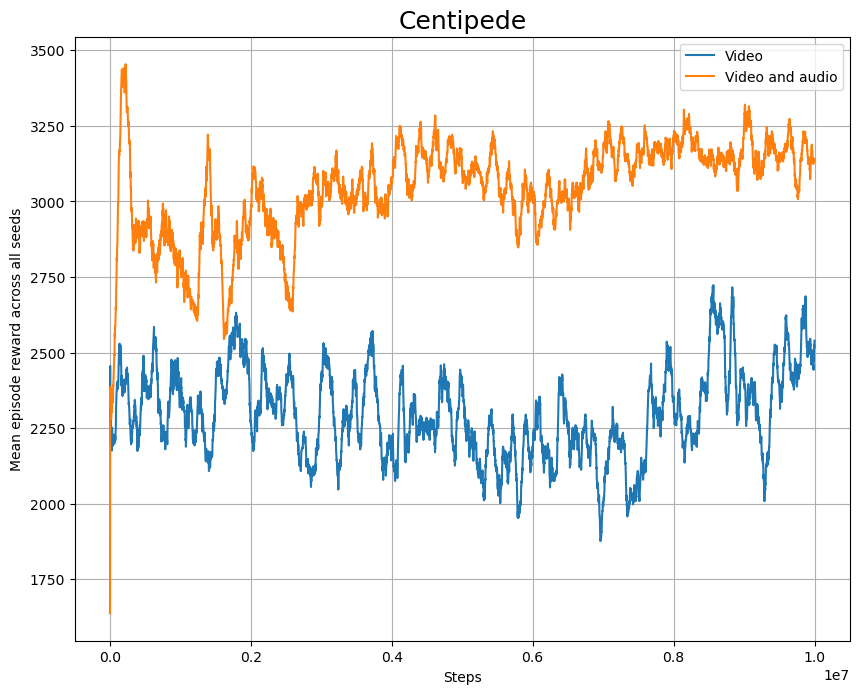

In [8]:
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(centipede_video['step'], centipede_video['ep_rew_mean'], label='Video')
plt.plot(centipede_video_audio['step'], centipede_video_audio['ep_rew_mean'], label='Video and audio')
plt.title('Centipede', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds')
plt.legend()
plt.grid()
plt.show()

### VideoPinball

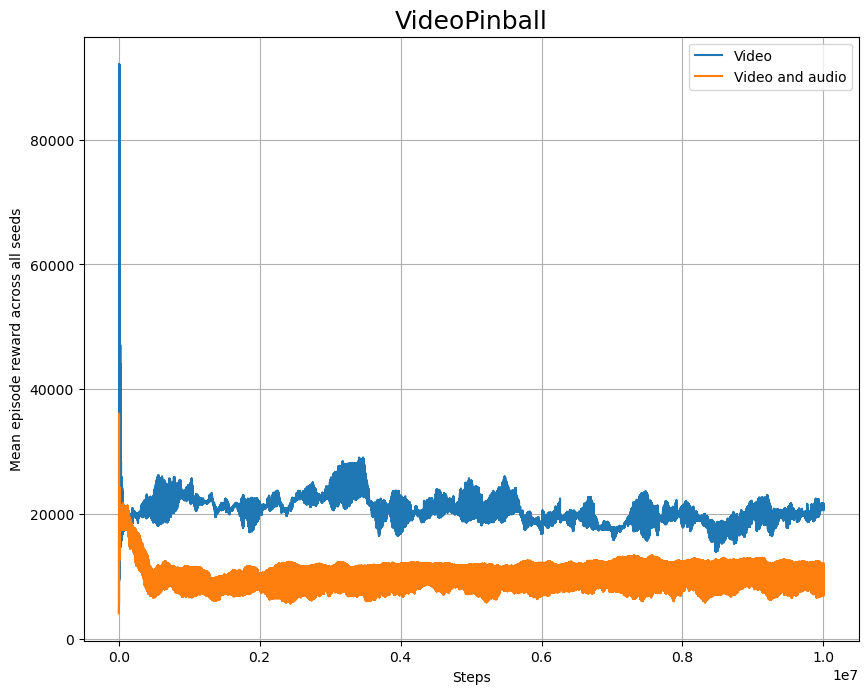

In [9]:
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(videopinball_video['step'], videopinball_video['ep_rew_mean'], label='Video')
plt.plot(videopinball_video_audio['step'], videopinball_video_audio['ep_rew_mean'], label='Video and audio')
plt.title('VideoPinball', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds')
plt.legend()
plt.grid()
plt.show()

## Visualise with moving average

To make lines smoother

In [11]:
window = 20

### Breakout

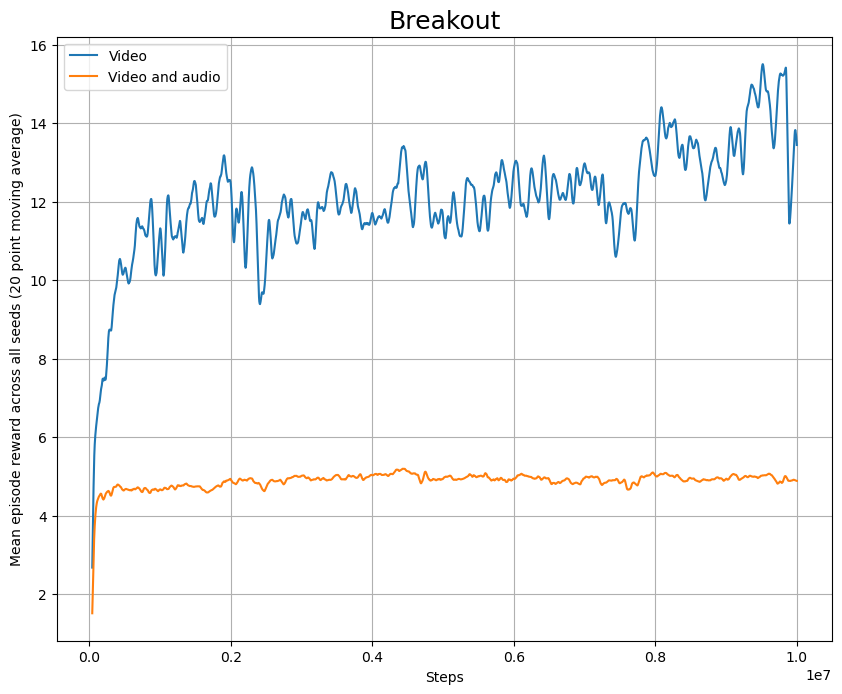

In [12]:
plt.figure(figsize=(10, 8), dpi=100)
moving_average_video = breakout_video['ep_rew_mean'].rolling(window=window).mean()
plt.plot(breakout_video['step'], moving_average_video, label = 'Video')
moving_average_video_audio = breakout_video_audio['ep_rew_mean'].rolling(window=window).mean()
plt.plot(breakout_video_audio['step'], moving_average_video_audio, label='Video and audio')
plt.title('Breakout', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds ({} point moving average)'.format(window))
plt.legend()
plt.grid()
plt.show()

### Centipede

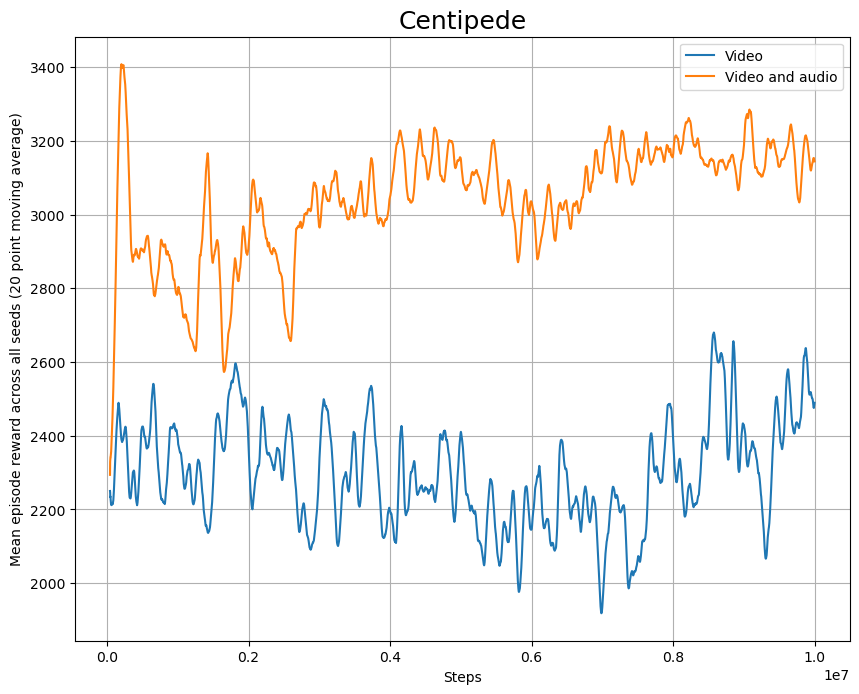

In [13]:
plt.figure(figsize=(10, 8), dpi=100)
moving_average_video = centipede_video['ep_rew_mean'].rolling(window=window).mean()
plt.plot(centipede_video['step'], moving_average_video, label = 'Video')
moving_average_video_audio = centipede_video_audio['ep_rew_mean'].rolling(window=window).mean()
plt.plot(centipede_video_audio['step'], moving_average_video_audio, label='Video and audio')
plt.title('Centipede', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds ({} point moving average)'.format(window))
plt.legend()
plt.grid()
plt.show()

### VideoPinball

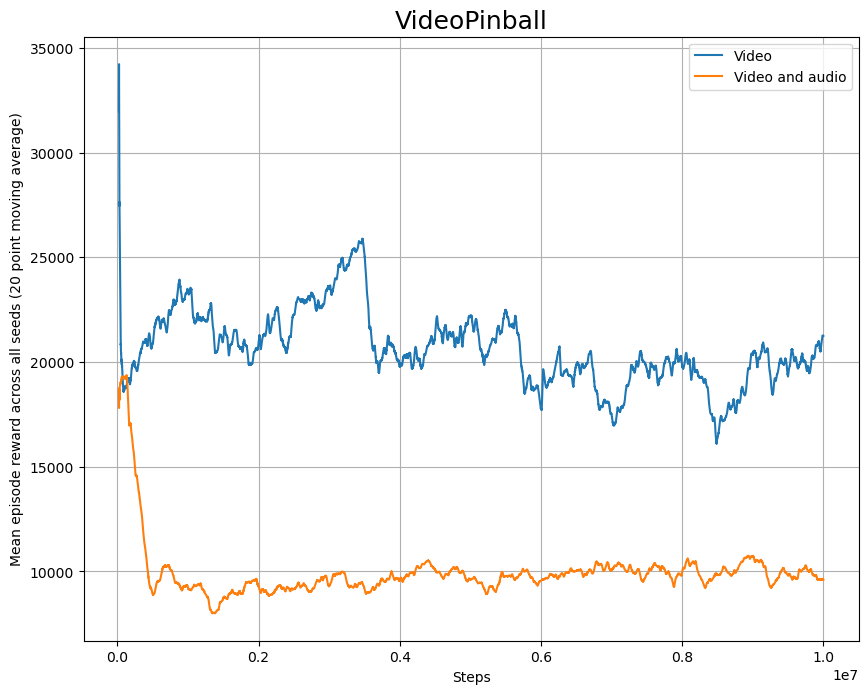

In [14]:
plt.figure(figsize=(10, 8), dpi=100)
moving_average_video = videopinball_video['ep_rew_mean'].rolling(window=window).mean()
plt.plot(videopinball_video['step'], moving_average_video, label='Video')
moving_average_video_audio = videopinball_video_audio['ep_rew_mean'].rolling(window=window).mean()
plt.plot(videopinball_video_audio['step'], moving_average_video_audio, label='Video and audio')
plt.title('VideoPinball', fontdict = {'size':18})
plt.xlabel('Steps')
plt.ylabel('Mean episode reward across all seeds ({} point moving average)'.format(window))
plt.legend()
plt.grid()
plt.show()

# Statistics

## Mean and Standard Deviation

### Average last 100 steps of all experiments including the one exceeding the threshold.

This is how performance is measured in "Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents" (M. Machado et. al, 2017)

In [15]:
breakout_scores_v = []
centipede_scores_v = []
videopinball_scores_v = []
breakout_scores_av = []
centipede_scores_av = []
videopinball_scores_av = []
for game in games:
    for mode in modes:
        for seed in seeds:
            scores = experiments[algorithms[0]][game][mode][seed]['ep_rew_mean']['ep_rew_mean']
            last_scores = scores.tail(100)
            average_last_scores = last_scores.mean()
            if game == 'Breakout':
                if mode == 'Video':
                    breakout_scores_v.append(average_last_scores)
                else: 
                    breakout_scores_av.append(average_last_scores)
            elif game == 'Centipede':
                if mode == 'Video':
                    centipede_scores_v.append(average_last_scores)
                else: 
                    centipede_scores_av.append(average_last_scores)
            elif game == 'VideoPinball':
                if mode == 'Video':
                    videopinball_scores_v.append(average_last_scores)
                else: 
                    videopinball_scores_av.append(average_last_scores)

Display the results

In [18]:
ix3 = pd.MultiIndex.from_arrays([
     ['Breakout', 'Breakout', 'Breakout', 'Breakout', 
      'Centipede', 'Centipede', 'Centipede', 'Centipede', 
      'VideoPinball', 'VideoPinball', 'VideoPinball', 'VideoPinball'],
     ['1', '2', '3', '4', '1', '2', '3', '4', '1', '2', '3', '4']],
     names=['Game', 'Seed #'])

df = pd.DataFrame({'Video': breakout_scores_v + centipede_scores_v + videopinball_scores_v,
                    'Audio + Video': breakout_scores_av + centipede_scores_av + videopinball_scores_av}, index=ix3)
df

Video  Audio + Video
Game         Seed #                             
Breakout     1          15.717300       5.682100
             2          12.576600       5.818600
             3          16.779000       6.182200
             4           8.353600       1.993200
Centipede    1        2973.486997    3092.099797
             2        2724.343308    2909.938298
             3        1977.541007    3260.192605
             4        2501.765293    3387.461594
VideoPinball 1       17776.006816   16800.710938
             2       20890.286406    7948.591011
             3       21409.498516    7219.386602
             4       20692.020352   12129.980469

### Calculate mean and SD

In [19]:
gp = df.groupby(level=('Game'))
means = gp.mean()
means

,Video,Audio + Video
Game,,
Breakout,13.356625,4.919025
Centipede,2544.284151,3162.423074
VideoPinball,20191.953022,11024.667255


In [20]:
errors = gp.std(ddof=1)
errors

,Video,Audio + Video
Game,,
Breakout,3.782598,1.961936
Centipede,424.123421,207.280118
VideoPinball,1638.795284,4416.891963


### Display barplots

Breakout

Text(0.5, 0, '')

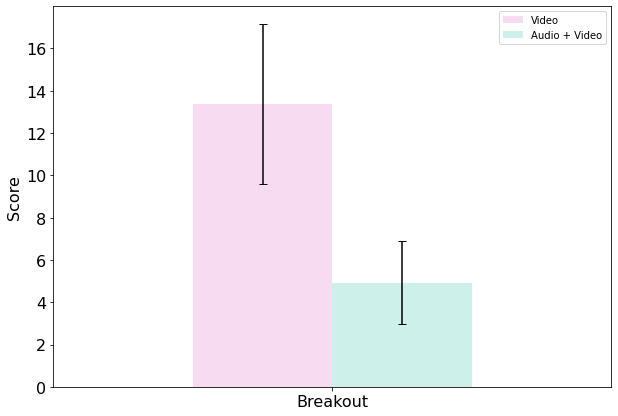

In [21]:
fig, ax = plt.subplots()
means.iloc[[0]].plot.bar(yerr=errors.iloc[[0]], ax=ax, capsize=4, rot=0, figsize=(10, 7), fontsize=16, color=('#F7DBF0','#CDF0EA'))
plt.ylabel('Score', fontsize=16)
plt.xlabel('')

Centipede

Text(0.5, 0, '')

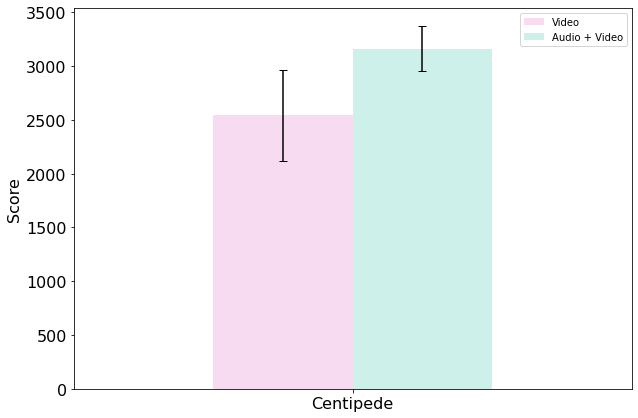

In [22]:
fig, ax = plt.subplots()
means.iloc[[1]].plot.bar(yerr=errors.iloc[[1]], ax=ax, capsize=4, rot=0, figsize=(10, 7), fontsize=16, color=('#F7DBF0','#CDF0EA'))
plt.ylabel('Score', fontsize=16)
plt.xlabel('')

VideoPinball

Text(0.5, 0, '')

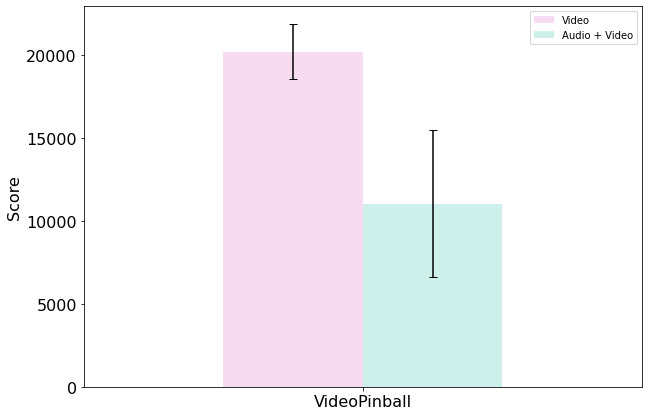

In [23]:
fig, ax = plt.subplots()
means.iloc[[2]].plot.bar(yerr=errors.iloc[[2]], ax=ax, capsize=4, rot=0, figsize=(10, 7), fontsize=16, color=('#F7DBF0','#CDF0EA'))
plt.ylabel('Score', fontsize=16)
plt.xlabel('')

## t-test

In [24]:
ttest_ind(df.loc['Breakout']['Video'], df.loc['Breakout']['Audio + Video'], equal_var=False)

Ttest_indResult(statistic=3.960263042806952, pvalue=0.013208049060274608)

In [30]:
ttest_ind(df.loc['Centipede']['Video'], df.loc['Centipede']['Audio + Video'], equal_var=False)

Ttest_indResult(statistic=-2.6188699631359023, pvalue=0.054035985668218586)

In [31]:
ttest_ind(df.loc['VideoPinball']['Video'], df.loc['VideoPinball']['Audio + Video'], equal_var=False)

Ttest_indResult(statistic=3.8917707964165995, pvalue=0.019359706618214418)